## 术语及共识

在抽卡游戏中, 每一抽对应的概率都可能有所不同. 每抽中奖的概率 $\mathbf{p}=(p_0,p_1,\cdots)$,
即前 $i-1$ 抽没抽中时, 第 $i$ 次抽奖的中奖概率为 $p_{i-1}$.

将玩家抽卡的过程建模成一个马尔可夫过程.

- 记**玩家已经在小保底卡池中投入 $i$ 抽** 的状态为 $S_i$.
- 记**玩家已经在大保底卡池中投入 $i$ 抽** 的状态为 $S_i^\prime$.

在每个状态下, 玩家的选择只有两种: 抽或不抽.
第 $i$ 抽能抽中的概率为 $p_{i-1}$.
当玩家抽中稀有角色时, 会进行歪判定, 记不歪的概率为 $p^\prime$.

- 如果玩家抽中且不歪, 状态转移到结束状态 $S_w$.
- 如果玩家抽中且歪, 状态转移到 $S_0^\prime$.
- 如果没有抽中, 玩家则转入状态 $S_{i+1}$.

该过程的状态转移图如图所示:

![二游抽卡状态转移图](gotcha-markov.svg)

记 $P_{0w}(m)$ 为从小保底水位为 $0$ 开始, 使用 $m$ 抽获得五星限定角色的概率.
也就是从马尔科夫链中的状态 $S_0$ 转移到 $S_w$ 花费 $m$ 步的概率.

二游厂商都会有抽卡的保底机制, 即 $n$ 抽必定至少中奖一次.
保底机制又可以分为硬保底和软保底.

硬保底指在触及保底抽数前的抽数为一恒定小值, 即

$$
p_i =
\begin{cases}
\epsilon & \text{if } i < n, \\
1 & \text{if } i = n.
\end{cases}
$$

软保底指抽卡概率会随着抽数增加而增加.


## 尘白禁区当前角色卡池分析

事实:

- 小保底后必有大保底.
- 抽中五星角色时, 保底机制重置
- 只考虑一直抽, 直到抽到五星限定角色的情况.
- 尘白禁区的抽卡概率遵从软保底机制.
- 小保底不歪概率为 $50\%$.

猜测:

- 每次保底过程中的抽卡概率从第 $t$ 抽开始**线性**上升, 在第 $80$ 抽达到 $1$.

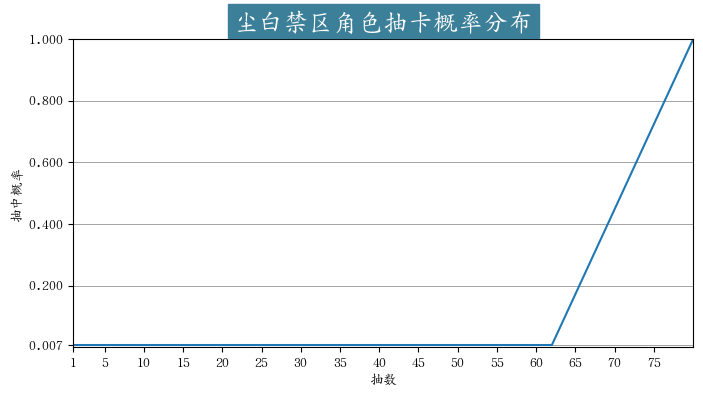

In [1]:
base_p = 0.007
threshold = 62
end = 80
win_fifty_fifty = 0.5

def gen_linear_probability(base_p: float, threshold: int, end: int) -> list[float]:
    """
    生成以 base_p 为基础概率, 从第 threshold 抽开始, 
    概率线性提高, 直到第 end 抽概率为 1 的概率分布.
    p[i] 代表第 i + 1 抽时获得五星角色的概率
    """
    k = (1 - base_p) / (end - threshold)
    b = 1 - k * end
    p = []
    for i in range(end):
        if i + 1 <= threshold:
            p.append(base_p)
        else:
            p.append(k * (i+1) + b)
    return p

p = gen_linear_probability(base_p, threshold, end)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AR PL KaitiM GB"

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(1, 80)
ax.set_ylim(0, 1)
ax.set_xticks(np.concatenate((np.array([1]), np.arange(5, 80, 5))))
ax.set_yticks(np.append(np.linspace(0.2, 1, 5), base_p))
ax.set_xlabel("抽数")
ax.set_ylabel("抽中概率")
ax.set_title('尘白禁区角色抽卡概率分布', fontsize=18, 
             backgroundcolor='#3c7f99',
             fontweight='bold', color='white')
ax.yaxis.grid(linewidth=0.5, color='black', alpha=0.5)
ax.set_axisbelow(True)
ax.plot([i+1 for i in range(end)], p)
plt.show()

In [2]:
import numpy as np

def gen_transition_matrix(p: list[float], win_fifty_fifty_p: float):
    n = len(p)
    matrix = np.zeros((2*n+2, 2*n+2))
    matrix[2*n, 2*n+1] = 1
    matrix[2*n+1, 2*n+1] = 1

    for i in range(n):
        if i < n - 1:
            matrix[i, i+1] = 1 - p[i]
            matrix[i+n, i+n+1] = 1 - p[i]

        matrix[i, n] = p[i] * (1 - win_fifty_fifty_p)
        matrix[i, 2 * n] = p[i] * win_fifty_fifty_p
        matrix[i+n, 2 * n] = p[i]

    return matrix

In [3]:
A = gen_transition_matrix(gen_linear_probability(base_p,threshold,end), 0.5)
A

array([[0.    , 0.993 , 0.    , ..., 0.    , 0.0035, 0.    ],
       [0.    , 0.    , 0.993 , ..., 0.    , 0.0035, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.0035, 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]])

## 蒙特卡洛统计模仿法求期望

In [4]:
import numpy as np

def step_markov_chain(transition_matrix, initial_state, end_state):
    current_state = initial_state
    n = len(transition_matrix)
    step = 0

    # 逐步进行马尔可夫链的步进，直到达到终止状态
    while True:
        if current_state == end_state:
            break

        # 根据当前状态选择下一个状态
        next_state = np.random.choice(
            range(n), p=transition_matrix[current_state])
        step += 1

        # 更新当前状态
        current_state = next_state
    return step

# 定义转移概率矩阵
transition_matrix = A

# 初始状态
initial_state = 0

# 开始步进马尔可夫链
rounds = 10 ** 4
sum_step = 0
for i in range(rounds):
    sum_step += step_markov_chain(transition_matrix, 0, 2*len(p))

exception = sum_step / rounds
exception

80.0239

## 序列求和求期望

In [5]:
def get_exact_p(p:list[float], transition_matrix:np.ndarray):
    exact_p = []
    init = np.zeros(2*len(p)+2)
    init[0]=1
    temp = np.dot(init, transition_matrix)
    for i in range(1, 2 * len(p) + 1):
        # temp[0, 2 * len(p)] 为经过 i 次抽卡后, 第一次抽中五星限定的概率
        exact_p.append(temp[2 * len(p)])
        temp = np.dot(temp, transition_matrix)

    return exact_p

def get_exception(p:list[float], exact_p:list[float]):
    exception = 0
    for i in range(1, 2 * len(p) + 1):
        exception += i * exact_p[i-1]
    return exception

def get_std_dev(data, weights):
    weighted_mean = np.average(data, weights=weights)
    weighted_variance = np.average((data - weighted_mean)**2, weights=weights)
    weighted_std_dev = np.sqrt(weighted_variance)
    return weighted_std_dev

exact_p = get_exact_p(p, A)
print(f'限定池中获取当期限定角色的期望抽数为:{get_exception(p, exact_p)}, \
      标准差为:{get_std_dev([i for i in range(1, 2*len(p)+1)], exact_p)}')

限定池中获取当期限定角色的期望抽数为:80.43071219263079,       标准差为:37.12760422244179


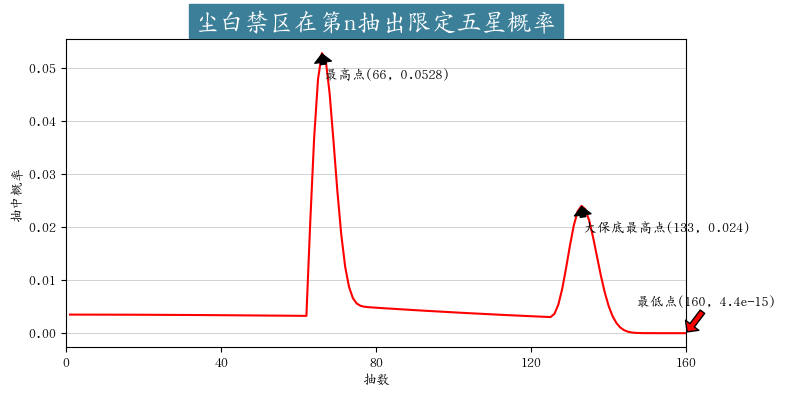

In [6]:
plt.rcParams["font.family"] = "AR PL KaitiM GB"

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(1, 2 * len(p))
# p_ax.set_ylim(0, 1)
ax.set_xticks(np.linspace(0, 2 * len(p), 5))
ax.set_xlabel("抽数")
ax.set_ylabel("抽中概率")
ax.set_title('尘白禁区在第n抽出限定五星概率', fontsize=18,
             backgroundcolor='#3c7f99', fontweight='bold', color='white')
ax.yaxis.grid(linewidth=0.5, color='gray', alpha=0.5)
ax.set_axisbelow(True)
max_index = np.argmax(exact_p)
# 找到小保底最高点的索引
start_index = len(p)
end_index = 2 * len(p)
second_highest_index = start_index + np.argmax(exact_p[start_index:end_index])
min_index = np.argmin(exact_p)
x = [i for i in range(1, 2 * end + 1)]
ax.plot(x, exact_p, 'r-')
# ax.legend(loc='best', labelspacing=2, handlelength=3, fontsize=14, shadow=True)
# 标注最高点
ax.annotate(f'最高点({x[max_index]}, {exact_p[max_index]:.3g})',
            xy=(x[max_index], exact_p[max_index]), xytext=(
                x[max_index]+0.5, exact_p[max_index]-0.005),
            arrowprops=dict(facecolor='black', shrink=0.05, headwidth=12, headlength=6, width=4))
# 标注大保底最高点
ax.annotate(f'大保底最高点({x[second_highest_index]}, {exact_p[second_highest_index]:.3g})',
            xy=(x[second_highest_index], exact_p[second_highest_index]), xytext=(
                x[second_highest_index]+0.5, exact_p[second_highest_index]-0.005),
            arrowprops=dict(facecolor='black', shrink=0.05, headwidth=12, headlength=6, width=4))
# 标注最低点
ax.annotate(f'最低点({x[min_index]}, {exact_p[min_index]:.2g})',
            xy=(x[min_index], exact_p[min_index]), xytext=(
                x[min_index]-13, exact_p[min_index]+0.005),
            arrowprops=dict(facecolor='red', shrink=0.05, headwidth=12, headlength=6, width=4))
plt.show()

官方公布的橙色品质角色含保底的出货概率为$1.86\%$.
通过这一概率, 估算可能的软保底阈值.

In [7]:
base_p = 0.007
end = 80
win_fifty_fifty = 1
for threshold in range(40, 80):
    p = gen_linear_probability(base_p, threshold, end)
    A = gen_transition_matrix(p, win_fifty_fifty)
    exact_p = get_exact_p(p, A)
    exception = get_exception(p, exact_p)
    avg_p = 1 / exception
    print(threshold, exception, avg_p)

40 40.57190995998208 0.02464759487503412
41 41.21786242774707 0.024261326063498605
42 41.85882689006218 0.023889823826797513
43 42.49481054146025 0.02353228517219404
44 43.125818662866244 0.023187965608663475
45 43.75185445014056 0.022856174042624775
46 44.372918819771705 0.022536268214891908
47 44.98901018794982 0.022227650615612948
48 45.60012421849907 0.021929764822752825
49 46.20625353421283 0.02164209221722689
50 46.807387384975414 0.021364149034325028
51 47.4035112645964 0.02109548371676965
52 47.99460646644695 0.020835674539786055
53 48.580649565650745 0.02058432748307788
54 49.16161181258725 0.020341074328729836
55 49.73745841859631 0.020105570967938937
56 50.30814770972371 0.019877495903247437
57 50.873630117703314 0.019656548936774494
58 51.43384696852489 0.01944245003901717
59 51.98872901703347 0.019234938397366133
60 52.53819465978744 0.019033771648902825
61 53.08214773600876 0.0188387253088036
62 53.62047479508721 0.01864959241449353
63 54.15304166444322 0.0184661834176638